In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
import root_pandas as rp


%matplotlib inline

SMALL_SIZE = 20
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

ImportError: No module named ROOT

In [ ]:
np.absolute

# Study Delta

In [ ]:
baseFolder="/d/grid17/ln16/myDSelector"

In [13]:
columns=[
    "Mpi0eta", "Ebeam","mandelstam_t",
    "cosTheta_eta_gj", "phi_eta_gj", "cosTheta_eta_hel", "phi_eta_hel", 
    "cosTheta_eta_cm","cosTheta_pi0_cm", "vanHove_omega", "vanHove_x", "vanHove_y",
    "Mpi0p","Metap",
    "AccWeight","weightBS","weightASBS"
]

data_tmp=rp.read_root("/d/grid17/ln16/myDSelector/degALL_data_2018_8_mEllipse_mDelta_treeFlat_DSelector.root",
                 columns=columns)

In [14]:
res_masses=[1.23, 1.5, 1.65, 1.85]

Text(0,0.5,'t')

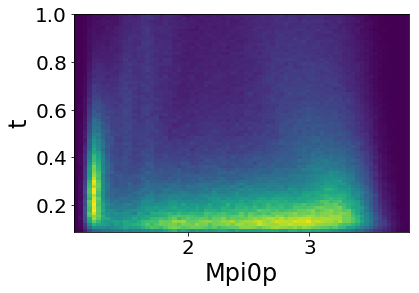

In [15]:
_=plt.hist2d(data_tmp.Mpi0p,data_tmp.mandelstam_t,bins=(75,75))
plt.xlabel("Mpi0p")
plt.ylabel("t")

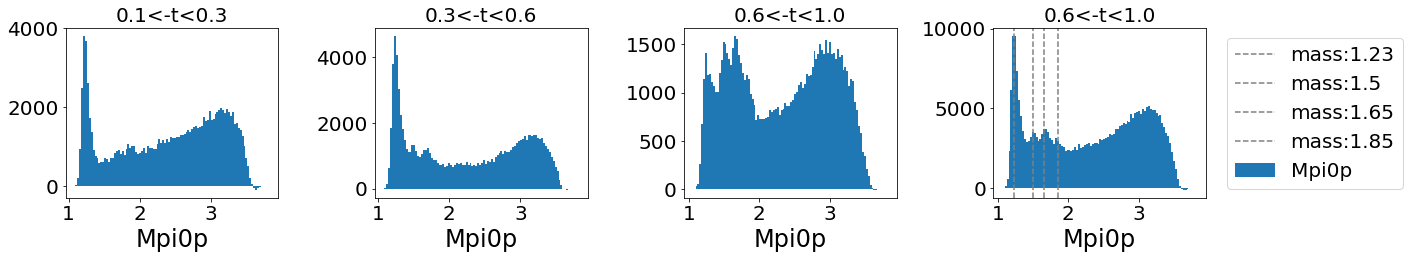

In [16]:
fig,axes=plt.subplots(1,4,figsize=(20,4))
_=axes[0].hist(data_tmp.loc[(data_tmp.mandelstam_t<0.3)&(data_tmp.mandelstam_t>0.1),"Mpi0p"],
               bins=100,
               weights=data_tmp.loc[(data_tmp.mandelstam_t<0.3)&(data_tmp.mandelstam_t>0.1),"weightASBS"])
axes[0].set_xlabel("Mpi0p")
axes[0].set_title(label="0.1<-t<0.3")

_=axes[1].hist(data_tmp.loc[(data_tmp.mandelstam_t<0.6)&(data_tmp.mandelstam_t>0.3),"Mpi0p"],
               bins=100,
               weights=data_tmp.loc[(data_tmp.mandelstam_t<0.6)&(data_tmp.mandelstam_t>0.3),"weightASBS"])
axes[1].set_xlabel("Mpi0p")
axes[1].set_title(label="0.3<-t<0.6")


_=axes[2].hist(data_tmp.loc[(data_tmp.mandelstam_t<1.0)&(data_tmp.mandelstam_t>0.6),"Mpi0p"],
               bins=100,
               weights=data_tmp.loc[(data_tmp.mandelstam_t<1.0)&(data_tmp.mandelstam_t>0.6),"weightASBS"])
axes[2].set_xlabel("Mpi0p")
axes[2].set_title(label="0.6<-t<1.0")

_=axes[3].hist(data_tmp["Mpi0p"],
               bins=100,
               weights=data_tmp["weightASBS"])
axes[3].set_xlabel("Mpi0p")
axes[3].set_title(label="0.6<-t<1.0")
for res_mass in res_masses:
    axes[3].axvline(res_mass,c='gray',linestyle='--',label="mass:{0}".format(res_mass))
axes[3].legend(bbox_to_anchor=(1.05,1))

plt.tight_layout()

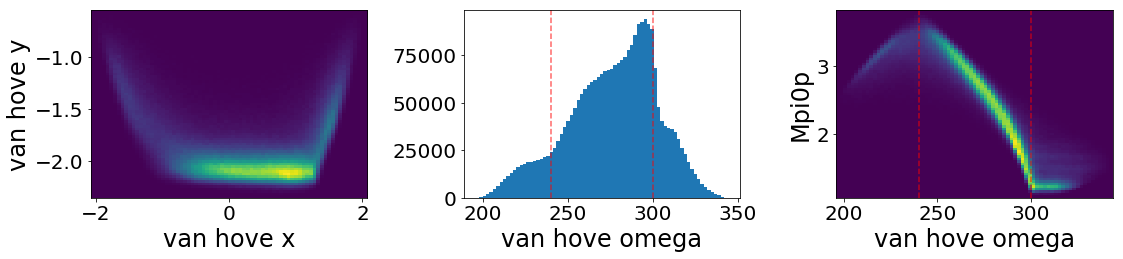

In [17]:
# Van Hove Selections
fig,axes=plt.subplots(1,3,figsize=(16,4))
_=axes[0].hist2d(data_tmp.vanHove_x,data_tmp.vanHove_y,bins=(75,75))
axes[0].set_xlabel("van hove x")
axes[0].set_ylabel("van hove y")
_=axes[1].hist(data_tmp.vanHove_omega,bins=75)
axes[1].set_xlabel("van hove omega")
axes[1].axvline(240,c='red',linestyle='--',alpha=0.6)
axes[1].axvline(300,c='red',linestyle='--',alpha=0.6)
_=axes[2].hist2d(data_tmp.vanHove_omega,data_tmp.Mpi0p,bins=(75,75))
axes[2].set_xlabel("van hove omega")
axes[2].set_ylabel("Mpi0p")
axes[2].axvline(240,c='red',linestyle='--',alpha=0.6)
axes[2].axvline(300,c='red',linestyle='--',alpha=0.6)
plt.tight_layout()

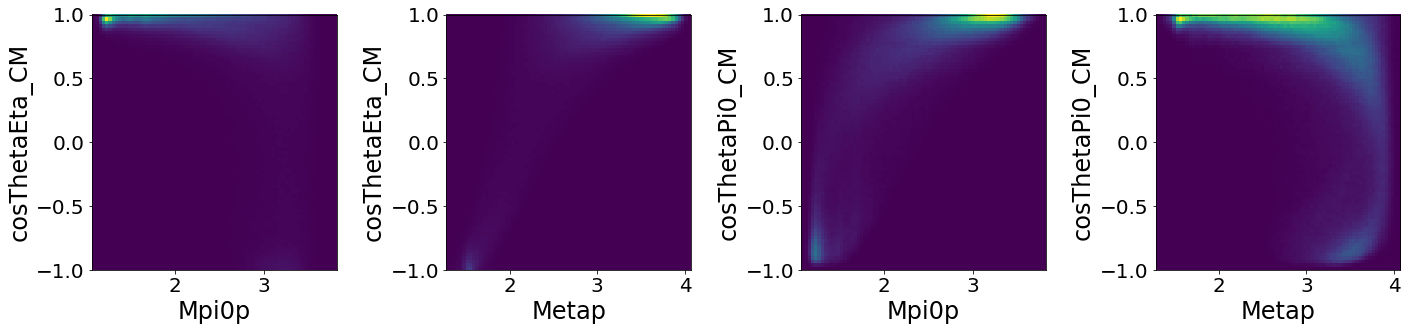

In [18]:
# Cos Theta CM
fig,axes=plt.subplots(1,4,figsize=(20,5))
_=axes[0].hist2d(data_tmp.Mpi0p,data_tmp.cosTheta_eta_cm,bins=(75,75))
axes[0].set_xlabel("Mpi0p")
axes[0].set_ylabel("cosThetaEta_CM")
_=axes[1].hist2d(data_tmp.Metap,data_tmp.cosTheta_eta_cm,bins=(75,75))
axes[1].set_xlabel("Metap")
axes[1].set_ylabel("cosThetaEta_CM")
_=axes[2].hist2d(data_tmp.Mpi0p,data_tmp.cosTheta_pi0_cm,bins=(75,75))
axes[2].set_xlabel("Mpi0p")
axes[2].set_ylabel("cosThetaPi0_CM")
_=axes[3].hist2d(data_tmp.Metap,data_tmp.cosTheta_pi0_cm,bins=(75,75))
axes[3].set_xlabel("Metap")
axes[3].set_ylabel("cosThetaPi0_CM")
plt.tight_layout()

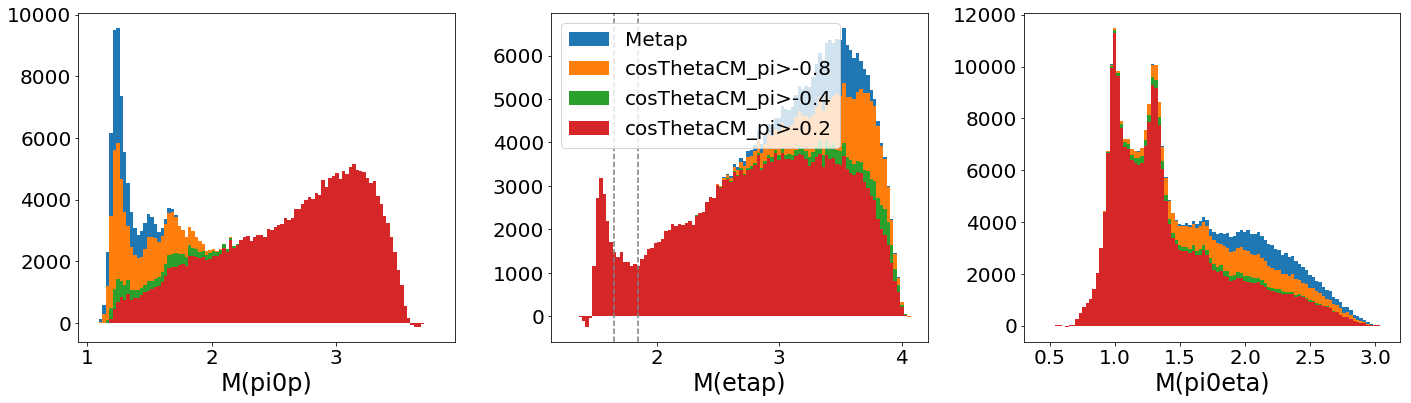

In [19]:
cutVar="cosTheta_pi0_cm"
fig,ax=plt.subplots(1,3,figsize=(20,6))
edges=np.histogram(data_tmp.Mpi0p,bins=100)[1]
_=ax[0].hist(data_tmp.Mpi0p,bins=edges,weights=data_tmp.weightASBS,label="total")
for thresh in [-0.8,-0.4,-0.2]:
    _=ax[0].hist(data_tmp.loc[data_tmp[cutVar]>thresh,"Mpi0p"],bins=edges,weights=data_tmp.loc[data_tmp[cutVar]>thresh,"weightASBS"],
                label="cosThetaCM_pi>"+str(thresh))
ax[0].set_xlabel("M(pi0p)")

edges=np.histogram(data_tmp.Metap,bins=100)[1]
_=ax[1].hist(data_tmp.Metap,bins=edges,weights=data_tmp.weightASBS)
for thresh in [-0.8,-0.4,-0.2]:
    _=ax[1].hist(data_tmp.loc[data_tmp[cutVar]>thresh,"Metap"],bins=edges,weights=data_tmp.loc[data_tmp[cutVar]>thresh,"weightASBS"],
                label="cosThetaCM_pi>"+str(thresh))
ax[1].set_xlabel("M(etap)")
ax[1].legend()
ax[1].axvline(1.65,c='gray',linestyle='--')
ax[1].axvline(1.85,c='gray',linestyle='--')


edges=np.histogram(data_tmp.Mpi0eta,bins=100)[1]
_=ax[2].hist(data_tmp.Mpi0eta,bins=edges,weights=data_tmp.weightASBS)
for thresh in [-0.8,-0.4,-0.2]:
    _=ax[2].hist(data_tmp.loc[data_tmp[cutVar]>thresh,"Mpi0eta"],bins=edges,weights=data_tmp.loc[data_tmp[cutVar]>thresh,"weightASBS"])
ax[2].set_xlabel("M(pi0eta)")

plt.tight_layout()


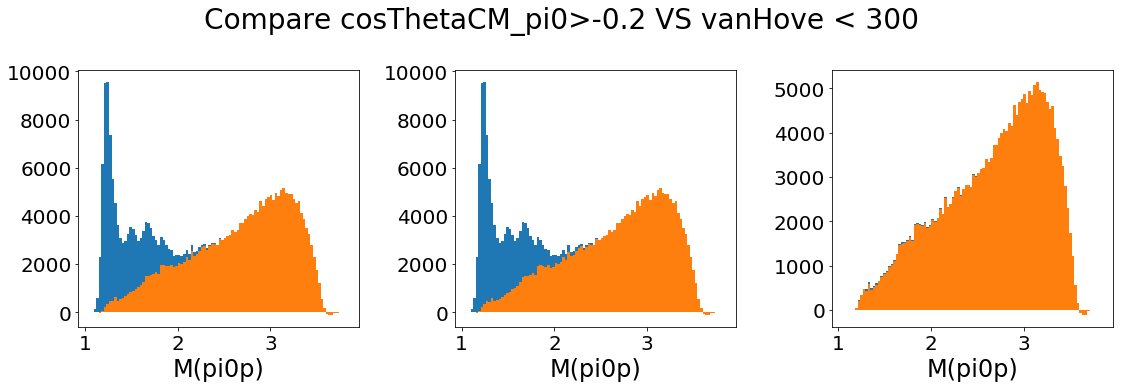

In [22]:
cutVar="cosTheta_pi0_cm"
fig,ax=plt.subplots(1,3,figsize=(16,5))
fig.suptitle("Compare cosThetaCM_pi0>-0.2 VS vanHove < 300",y=1.1)
edges=np.histogram(data_tmp.Mpi0p,bins=100)[1]
thresh=-0.02
_=ax[0].hist(data_tmp.Mpi0p,bins=edges,weights=data_tmp.weightASBS,label="total")
_=ax[0].hist(data_tmp.loc[data_tmp[cutVar]>thresh,"Mpi0p"],bins=edges,weights=data_tmp.loc[data_tmp[cutVar]>thresh,"weightASBS"],label="cut cosThetaCM_pi0")
ax[0].set_xlabel("M(pi0p)")

_=ax[1].hist(data_tmp.Mpi0p,bins=edges,weights=data_tmp.weightASBS,label="total")
_=ax[1].hist(data_tmp.loc[(data_tmp["vanHove_omega"]<300),"Mpi0p"],
             bins=edges,
             weights=data_tmp.loc[(data_tmp["vanHove_omega"]<300),"weightASBS"],label="cut VH omega")
ax[1].set_xlabel("M(pi0p)")

_=ax[2].hist(data_tmp.loc[data_tmp[cutVar]>thresh,"Mpi0p"],bins=edges,weights=data_tmp.loc[data_tmp[cutVar]>thresh,"weightASBS"],label="cut cosThetaCM_pi0")
_=ax[2].hist(data_tmp.loc[(data_tmp["vanHove_omega"]<300),"Mpi0p"],
             bins=edges,
             weights=data_tmp.loc[(data_tmp["vanHove_omega"]<300),"weightASBS"],label="cut VH omega")
ax[2].set_xlabel("M(pi0p)")
plt.tight_layout()

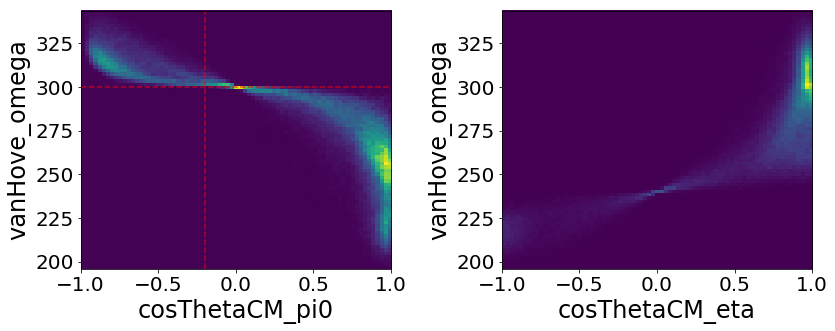

In [23]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
_=axes[0].hist2d(data_tmp["cosTheta_pi0_cm"],data_tmp["vanHove_omega"],bins=(75,75),weights=data_tmp["weightASBS"])
axes[0].set_xlabel("cosThetaCM_pi0")
axes[0].set_ylabel("vanHove_omega")
axes[0].axvline(-0.2,c='red',linestyle='--',alpha=0.6)
axes[0].axhline(300,c='red',linestyle='--',alpha=0.6)

_=axes[1].hist2d(data_tmp["cosTheta_eta_cm"],data_tmp["vanHove_omega"],bins=(75,75),weights=data_tmp["weightASBS"])
axes[1].set_xlabel("cosThetaCM_eta")
axes[1].set_ylabel("vanHove_omega")
plt.tight_layout()

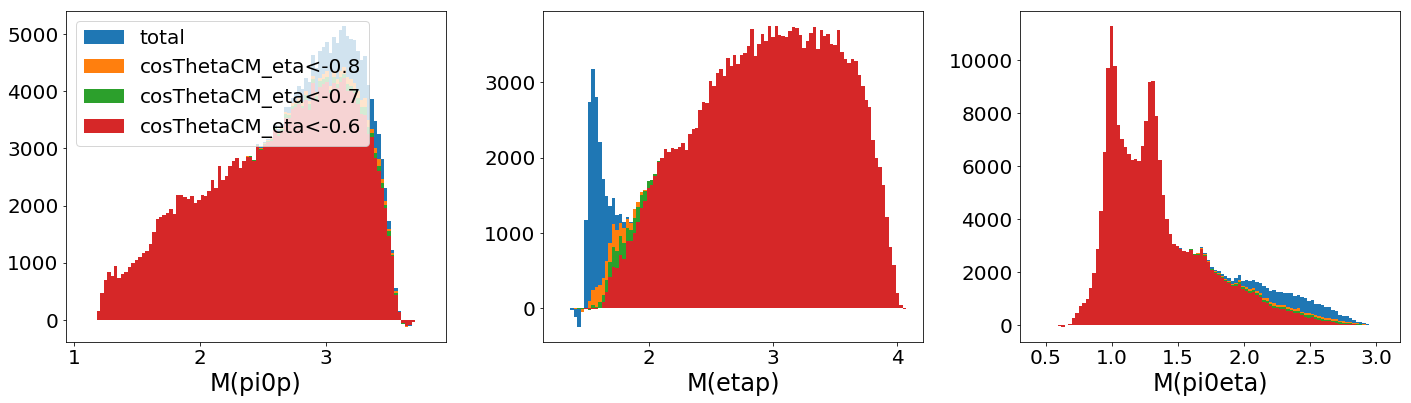

In [24]:
cutVar="cosTheta_eta_cm"
fig,ax=plt.subplots(1,3,figsize=(20,6))
edges=np.histogram(data_tmp.Mpi0p,bins=100)[1]
tmp=data_tmp[data_tmp.cosTheta_pi0_cm>-0.2]

_=ax[0].hist(tmp.Mpi0p,bins=edges,weights=tmp.weightASBS,label="total")
for thresh in [-0.8,-0.7,-0.6]:
    _=ax[0].hist(tmp.loc[tmp[cutVar]>thresh,"Mpi0p"],bins=edges,weights=tmp.loc[tmp[cutVar]>thresh,"weightASBS"],
                label="cosThetaCM_eta<"+str(thresh))
ax[0].set_xlabel("M(pi0p)")
ax[0].legend()

edges=np.histogram(tmp.Metap,bins=100)[1]
_=ax[1].hist(tmp.Metap,bins=edges,weights=tmp.weightASBS)
for thresh in [-0.8,-0.7,-0.6]:
    _=ax[1].hist(tmp.loc[tmp[cutVar]>thresh,"Metap"],bins=edges,weights=tmp.loc[tmp[cutVar]>thresh,"weightASBS"])
ax[1].set_xlabel("M(etap)")

edges=np.histogram(tmp.Mpi0eta,bins=100)[1]
_=ax[2].hist(tmp.Mpi0eta,bins=edges,weights=tmp.weightASBS)
for thresh in [-0.8,-0.7,-0.6]:
    _=ax[2].hist(tmp.loc[data_tmp[cutVar]>thresh,"Mpi0eta"],bins=edges,weights=tmp.loc[data_tmp[cutVar]>thresh,"weightASBS"])
ax[2].set_xlabel("M(pi0eta)")

plt.tight_layout()

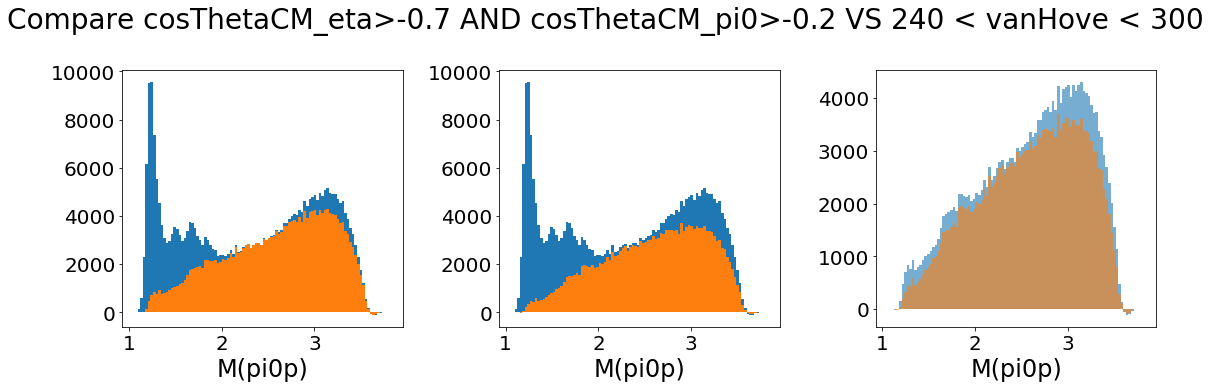

In [25]:
cutVar="cosTheta_pi0_cm"
fig,ax=plt.subplots(1,3,figsize=(16,5))
fig.suptitle("Compare cosThetaCM_eta>-0.7 AND cosThetaCM_pi0>-0.2 VS 240 < vanHove < 300",y=1.1)
edges=np.histogram(data_tmp.Mpi0p,bins=100)[1]
_=ax[0].hist(data_tmp.Mpi0p,bins=edges,weights=data_tmp.weightASBS,label="total")
_=ax[0].hist(data_tmp.loc[(data_tmp["cosTheta_eta_cm"]>-0.7)&(data_tmp["cosTheta_pi0_cm"]>-0.2),"Mpi0p"],bins=edges,
             weights=data_tmp.loc[(data_tmp["cosTheta_eta_cm"]>-0.7)&(data_tmp["cosTheta_pi0_cm"]>-0.2),"weightASBS"],label="cut cosThetaCM_pi0")
ax[0].set_xlabel("M(pi0p)")

_=ax[1].hist(data_tmp.Mpi0p,bins=edges,weights=data_tmp.weightASBS,label="total")
_=ax[1].hist(data_tmp.loc[(data_tmp["vanHove_omega"]>240)&(data_tmp["vanHove_omega"]<300),"Mpi0p"],
             bins=edges,
             weights=data_tmp.loc[(data_tmp["vanHove_omega"]>240)&(data_tmp["vanHove_omega"]<300),"weightASBS"],label="cut VH omega")
ax[1].set_xlabel("M(pi0p)")

_=ax[2].hist(data_tmp.loc[(data_tmp["cosTheta_eta_cm"]>-0.7)&(data_tmp["cosTheta_pi0_cm"]>-0.2),"Mpi0p"],bins=edges, alpha=0.6,
             weights=data_tmp.loc[(data_tmp["cosTheta_eta_cm"]>-0.7)&(data_tmp["cosTheta_pi0_cm"]>-0.2),"weightASBS"],label="cut cosThetaCM_pi0")
_=ax[2].hist(data_tmp.loc[(data_tmp["vanHove_omega"]>240)&(data_tmp["vanHove_omega"]<300),"Mpi0p"],
             bins=edges,
             weights=data_tmp.loc[(data_tmp["vanHove_omega"]>240)&(data_tmp["vanHove_omega"]<300),"weightASBS"],label="cut VH omega",alpha=0.6)
ax[2].set_xlabel("M(pi0p)")
plt.tight_layout()

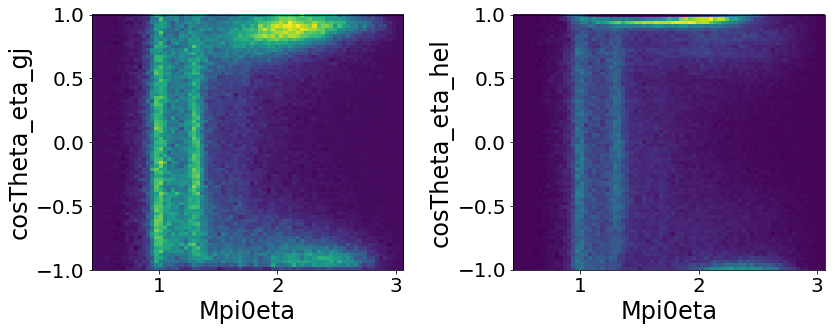

In [26]:
#########
# Full distribution
#########
fig,axes=plt.subplots(1,2,figsize=(12,5))
_=axes[0].hist2d(data_tmp["Mpi0eta"],data_tmp["cosTheta_eta_gj"],bins=(75,75),weights=data_tmp["weightASBS"])
axes[0].set_xlabel("Mpi0eta")
axes[0].set_ylabel("cosTheta_eta_gj")

_=axes[1].hist2d(data_tmp["Mpi0eta"],data_tmp["cosTheta_eta_hel"],bins=(75,75),weights=data_tmp["weightASBS"])
axes[1].set_xlabel("Mpi0eta")
axes[1].set_ylabel("cosTheta_eta_hel")

plt.tight_layout()

/d/home/ln16/.local/lib/python2.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


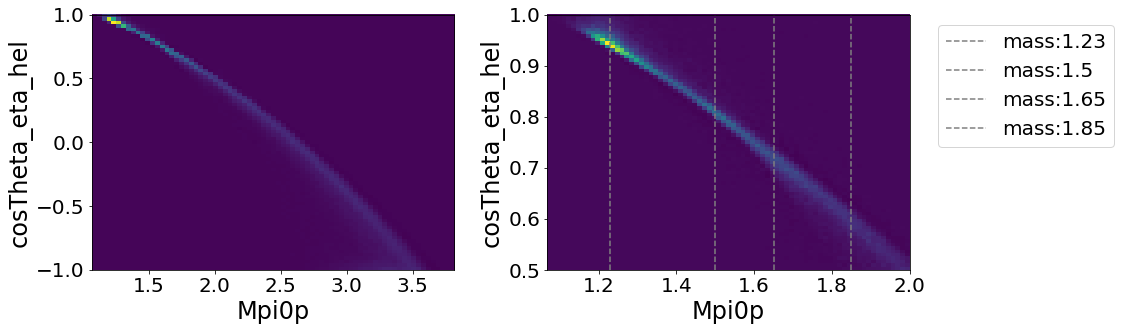

In [27]:
fig,ax=plt.subplots(1,2,figsize=(16,5))
_=ax[0].hist2d(data_tmp["Mpi0p"],data_tmp["cosTheta_eta_hel"],bins=(75,75),weights=data_tmp["weightASBS"])
ax[0].set_ylabel("cosTheta_eta_hel")
ax[0].set_xlabel("Mpi0p")

tmp=data_tmp[(data_tmp["Mpi0p"]<2)*(data_tmp["cosTheta_eta_hel"]>0.5)]
_=ax[1].hist2d(tmp["Mpi0p"],tmp["cosTheta_eta_hel"],bins=(75,75),weights=tmp["weightASBS"])
ax[1].set_ylabel("cosTheta_eta_hel")
ax[1].set_xlabel("Mpi0p")
for res_mass in res_masses:
    ax[1].axvline(res_mass,c='gray',linestyle='--',label="mass:{0}".format(res_mass))
ax[1].legend(bbox_to_anchor=(1.05,1))

plt.tight_layout()

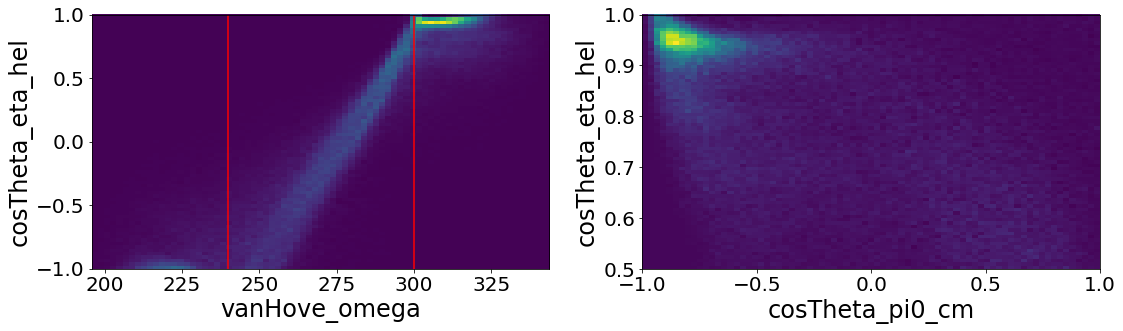

In [28]:
fig,ax=plt.subplots(1,2,figsize=(16,5))
_=ax[0].hist2d(data_tmp["vanHove_omega"],data_tmp["cosTheta_eta_hel"],bins=(75,75),weights=data_tmp["weightASBS"])
ax[0].set_ylabel("cosTheta_eta_hel")
ax[0].set_xlabel("vanHove_omega")
ax[0].axvline(300,c='red')
ax[0].axvline(240,c='red')

_=ax[1].hist2d(tmp["cosTheta_pi0_cm"],tmp["cosTheta_eta_hel"],bins=(75,75),weights=tmp["weightASBS"])
ax[1].set_ylabel("cosTheta_eta_hel")
ax[1].set_xlabel("cosTheta_pi0_cm")

plt.tight_layout()

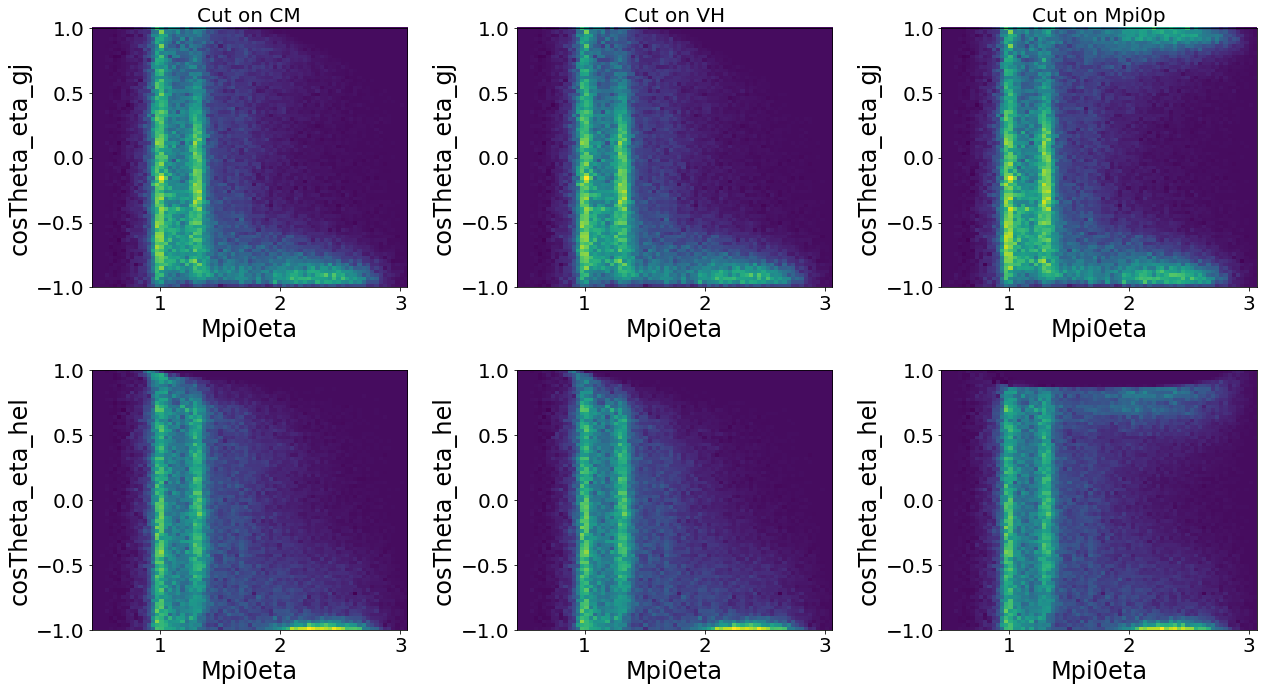

In [29]:
fig,axes=plt.subplots(2,3,figsize=(18,10))

for ivar, var in  enumerate(["cosTheta_eta_gj", "cosTheta_eta_hel"]):
    tmp=data_tmp[data_tmp.cosTheta_pi0_cm>-0.2]
    _=axes[ivar,0].hist2d(tmp["Mpi0eta"],tmp[var],bins=(75,75),weights=tmp["weightASBS"])
    axes[ivar,0].set_xlabel("Mpi0eta")
    axes[ivar,0].set_ylabel(var)
    if ivar==0:
        axes[ivar,0].set_title("Cut on CM")
    
    tmp=data_tmp[data_tmp.vanHove_omega<300]
    _=axes[ivar,1].hist2d(tmp["Mpi0eta"],tmp[var],bins=(75,75),weights=tmp["weightASBS"])
    axes[ivar,1].set_xlabel("Mpi0eta")
    axes[ivar,1].set_ylabel(var)
    if ivar==0:
        axes[ivar,1].set_title("Cut on VH")

    tmp=data_tmp[data_tmp.Mpi0p>1.4]
    _=axes[ivar,2].hist2d(tmp["Mpi0eta"],tmp[var],bins=(75,75),weights=tmp["weightASBS"])
    axes[ivar,2].set_xlabel("Mpi0eta")
    axes[ivar,2].set_ylabel(var)
    if ivar==0:
        axes[ivar,2].set_title("Cut on Mpi0p")
    
plt.tight_layout()

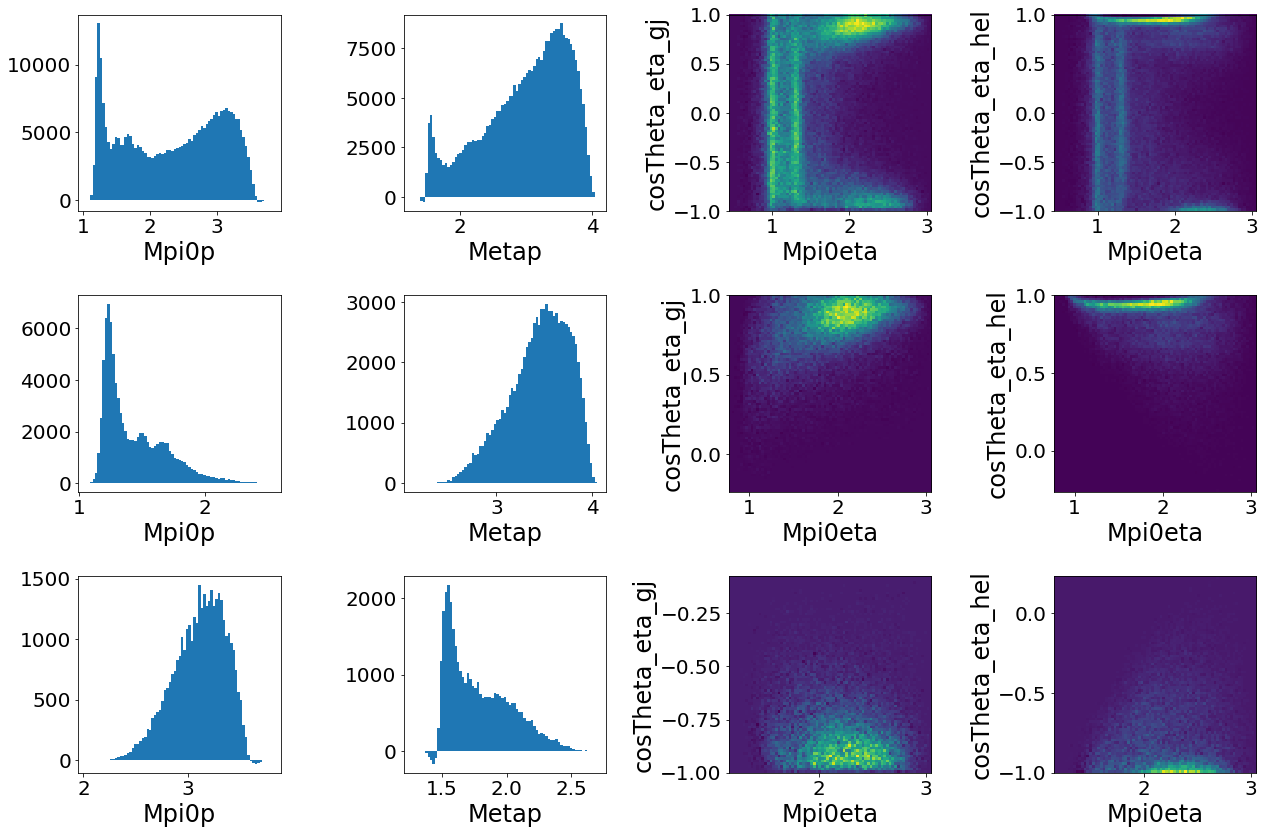

In [30]:
fig,axes=plt.subplots(3,4,figsize=(18,12))

vars=[
    ["Mpi0p"],
    ["Metap"],
    ["Mpi0eta","cosTheta_eta_gj"],
    ["Mpi0eta","cosTheta_eta_hel"]
]

irow=0
for ivar, var in  enumerate(vars):
    tmp=data_tmp#[data_tmp.cosTheta_pi0_cm>-0.2]
    if len(var)==1:
        _=axes[irow,ivar].hist(tmp[var[0]],bins=75,weights=tmp["weightASBS"])
        axes[irow,ivar].set_xlabel(var[0])
    else:
        _=axes[irow,ivar].hist2d(tmp[var[0]],tmp[var[1]],bins=(75,75),weights=tmp["weightASBS"])
        axes[irow,ivar].set_xlabel(var[0])
        axes[irow,ivar].set_ylabel(var[1])
        
irow=1
for ivar, var in  enumerate(vars):
    tmp=data_tmp[data_tmp.vanHove_omega>300]
    if len(var)==1:
        _=axes[irow,ivar].hist(tmp[var[0]],bins=75,weights=tmp["weightASBS"])
        axes[irow,ivar].set_xlabel(var[0])
    else:
        _=axes[irow,ivar].hist2d(tmp[var[0]],tmp[var[1]],bins=(75,75),weights=tmp["weightASBS"])
        axes[irow,ivar].set_xlabel(var[0])
        axes[irow,ivar].set_ylabel(var[1])
        
irow=2
for ivar, var in  enumerate(vars):
    tmp=data_tmp[data_tmp.vanHove_omega<240]
    if len(var)==1:
        _=axes[irow,ivar].hist(tmp[var[0]],bins=75,weights=tmp["weightASBS"])
        axes[irow,ivar].set_xlabel(var[0])
    else:
        _=axes[irow,ivar].hist2d(tmp[var[0]],tmp[var[1]],bins=(75,75),weights=tmp["weightASBS"])
        axes[irow,ivar].set_xlabel(var[0])
        axes[irow,ivar].set_ylabel(var[1])

plt.tight_layout()

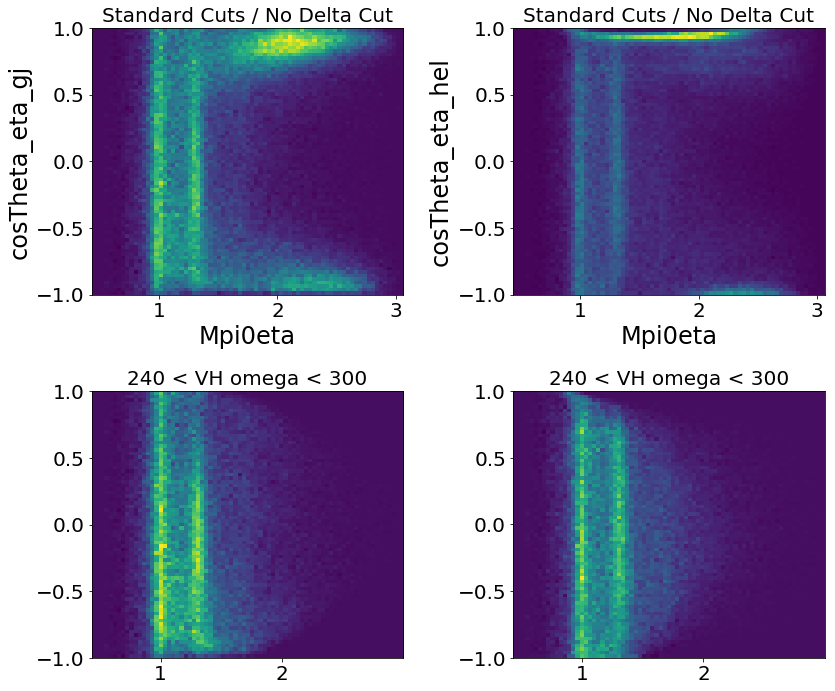

In [31]:
fig,axes=plt.subplots(2,2,figsize=(12,10))
axes=axes.flatten()

_=axes[0].hist2d(data_tmp["Mpi0eta"],data_tmp["cosTheta_eta_gj"],bins=(75,75),weights=data_tmp["weightASBS"])
_=axes[1].hist2d(data_tmp["Mpi0eta"],data_tmp["cosTheta_eta_hel"],bins=(75,75),weights=data_tmp["weightASBS"])
axes[0].set_ylabel("cosTheta_eta_gj")
axes[1].set_ylabel("cosTheta_eta_hel")
axes[0].set_xlabel("Mpi0eta")
axes[1].set_xlabel("Mpi0eta")
axes[0].set_title("Standard Cuts / No Delta Cut")
axes[1].set_title("Standard Cuts / No Delta Cut")

tmp=data_tmp[(data_tmp.vanHove_omega<300)*(data_tmp.vanHove_omega>240)]
_=axes[2].hist2d(tmp["Mpi0eta"],tmp["cosTheta_eta_gj"],bins=(75,75),weights=tmp["weightASBS"])
_=axes[3].hist2d(tmp["Mpi0eta"],tmp["cosTheta_eta_hel"],bins=(75,75),weights=tmp["weightASBS"])
axes[2].set_title("240 < VH omega < 300")
axes[3].set_title("240 < VH omega < 300")

plt.tight_layout()

In [32]:
acc_tmp=rp.read_root("/d/grid17/ln16/myDSelector/degALL_flat_2018_8_mEllipse_mDelta_treeFlat_DSelector.root",
                 columns=columns)

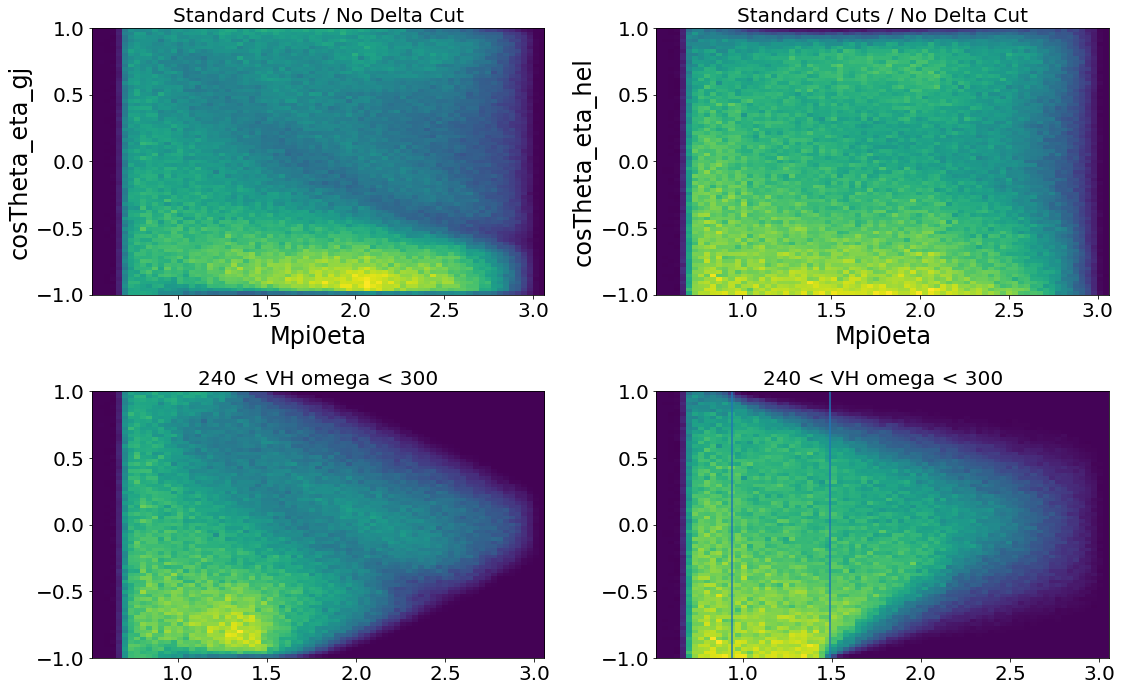

In [33]:
fig,axes=plt.subplots(2,2,figsize=(16,10))
axes=axes.flatten()

_=axes[0].hist2d(acc_tmp["Mpi0eta"],acc_tmp["cosTheta_eta_gj"],bins=(75,75),weights=acc_tmp["weightASBS"])
_=axes[1].hist2d(acc_tmp["Mpi0eta"],acc_tmp["cosTheta_eta_hel"],bins=(75,75),weights=acc_tmp["weightASBS"])
axes[0].set_ylabel("cosTheta_eta_gj")
axes[1].set_ylabel("cosTheta_eta_hel")
axes[0].set_xlabel("Mpi0eta")
axes[1].set_xlabel("Mpi0eta")
axes[0].set_title("Standard Cuts / No Delta Cut")
axes[1].set_title("Standard Cuts / No Delta Cut")

tmp=acc_tmp[(acc_tmp.vanHove_omega<300)*(acc_tmp.vanHove_omega>240)]
_=axes[2].hist2d(tmp["Mpi0eta"],tmp["cosTheta_eta_gj"],bins=(75,75),weights=tmp["weightASBS"])
_=axes[3].hist2d(tmp["Mpi0eta"],tmp["cosTheta_eta_hel"],bins=(75,75),weights=tmp["weightASBS"])
axes[2].set_title("240 < VH omega < 300")
axes[3].set_title("240 < VH omega < 300")
axes[3].axvline(0.938+0.55,label="Mass=0.938+0.55")
axes[3].axvline(0.938,label="Mass=0.938")

plt.tight_layout()

In [34]:
tmp=data_tmp[data_tmp.Mpi0p<1.4]
counts,edgex,edgey=np.histogram2d(tmp["Mpi0eta"],tmp["vanHove_omega"],bins=edges)

In [35]:
def getSigma(col,lowPercentile=16,upPercentile=84):
    gtzero=np.where(col>0)[0]
    if len(gtzero)>0:
        col=col[gtzero]
        edge=edgey[gtzero]
        flattened=[]
        for i in range(len(col)):
            flattened.extend([edge[i]]*int(col[i]))
        flattened=np.array(flattened)
        lower=np.percentile(flattened,lowPercentile)
        median=np.percentile(flattened,50)
        upper=np.percentile(flattened,upPercentile)
    else:
        lower,upper,median=(0,0,0)
    return lower,upper,median

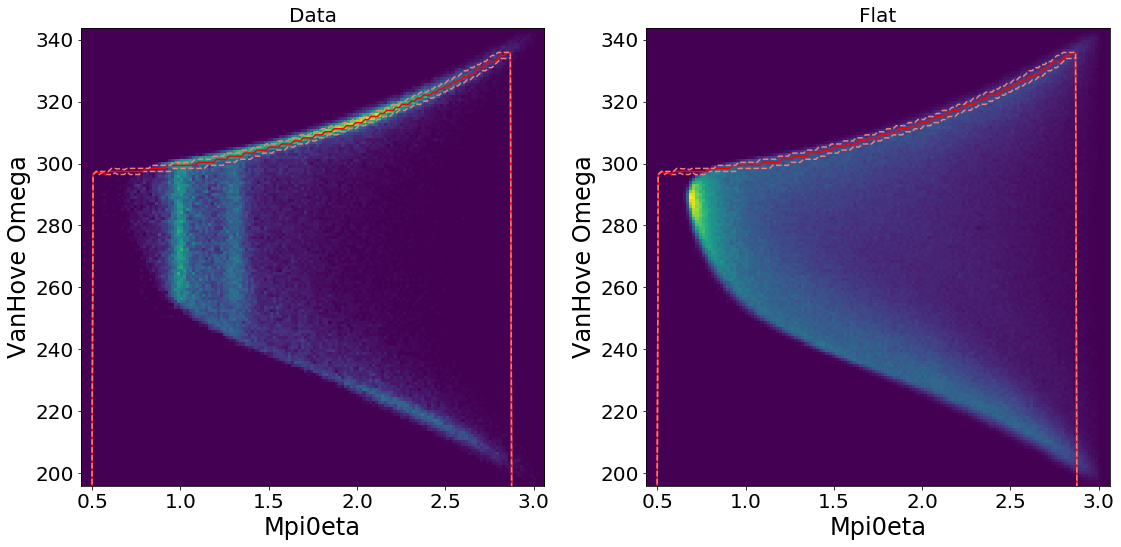

In [36]:
fig,axes=plt.subplots(1,2,figsize=(16,8))
edges=np.histogram2d(data_tmp["Mpi0eta"],data_tmp["vanHove_omega"],bins=(150,150))[1:]
_=axes[0].hist2d(data_tmp["Mpi0eta"],data_tmp["vanHove_omega"],bins=edges,weights=data_tmp["weightASBS"],vmin=0)
axes[0].set_xlabel("Mpi0eta")
axes[0].set_ylabel("VanHove Omega")
axes[0].set_title("Data")

tmp=data_tmp[(data_tmp.Mpi0p<1.4)]
counts,edgex,edgey=np.histogram2d(tmp["Mpi0eta"],tmp["vanHove_omega"],bins=edges)
lowers=[]
uppers=[]
medians=[]
for col in range(len(counts)):
    lower,upper,median=getSigma(counts[col,:])
    lowers.append(lower)
    uppers.append(upper)
    medians.append(median)
axes[0].plot(edgex[:-1],lowers,c='lightcoral',linestyle='--')
axes[0].plot(edgex[:-1],medians,c='red',linestyle='-')
axes[0].plot(edgex[:-1],uppers,c='lightcoral',linestyle='--')


_=axes[1].hist2d(acc_tmp["Mpi0eta"],acc_tmp["vanHove_omega"],bins=edges,weights=acc_tmp["weightASBS"],vmin=0)
axes[1].set_xlabel("Mpi0eta")
axes[1].set_ylabel("VanHove Omega")
axes[1].set_title("Flat")
axes[1].plot(edgex[:-1],lowers,c='lightcoral',linestyle='--')
axes[1].plot(edgex[:-1],medians,c='red',linestyle='-')
axes[1].plot(edgex[:-1],uppers,c='lightcoral',linestyle='--')

plt.tight_layout()

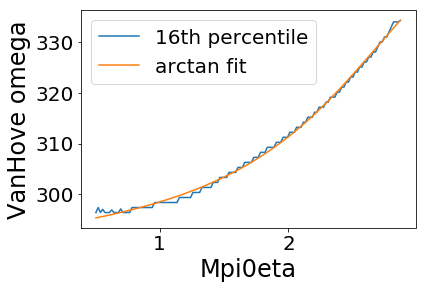

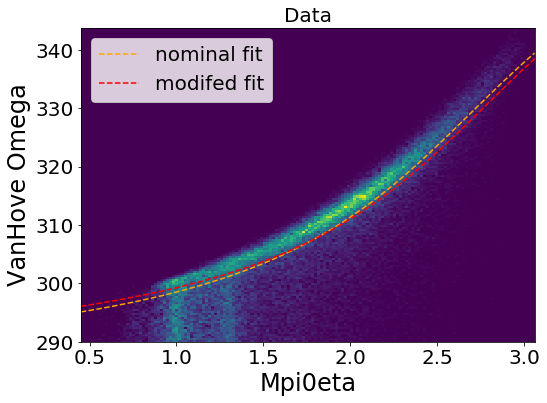

In [37]:
from scipy.optimize import curve_fit

def arctan(x,a,b,c,d):
    return a*np.arctan(b*(x-c))+d

percentiles=lowers
percentiles=np.array(percentiles)
percentilesGT0=np.where(percentiles>0)
percentiles=percentiles[percentilesGT0]
edges=edgex[:-1][percentilesGT0]
popt, pcov = curve_fit(arctan, edges, percentiles, p0=[-34.40782804,  -0.85071669,   2.77821283, 334.47225961])
plt.plot(edges,percentiles,label='16th percentile')
plt.plot(edges,arctan(edges,*popt),label='arctan fit')
plt.xlabel("Mpi0eta")
plt.ylabel("VanHove omega")
plt.legend()

########
# Modify the fit abit since it looks like it can perform better at low mass
########
fig,axes=plt.subplots(1,1,figsize=(8,6))

tmp=data_tmp[data_tmp.vanHove_omega>290]

edges=np.histogram2d(tmp["Mpi0eta"],tmp["vanHove_omega"],bins=(150,150))[1:]
_=axes.hist2d(tmp["Mpi0eta"],tmp["vanHove_omega"],bins=edges,weights=tmp["weightASBS"],vmin=0)
axes.set_xlabel("Mpi0eta")
axes.set_ylabel("VanHove Omega")
axes.set_title("Data")
axes.plot(edges[0],arctan(edges[0],*popt),c='orange',linestyle='--',label='nominal fit')
popt[2]+=0.09
popt[3]+=1.4
axes.plot(edges[0],arctan(edges[0],*popt),c='red',linestyle='--',label="modifed fit")
axes.legend()

plt.tight_layout()

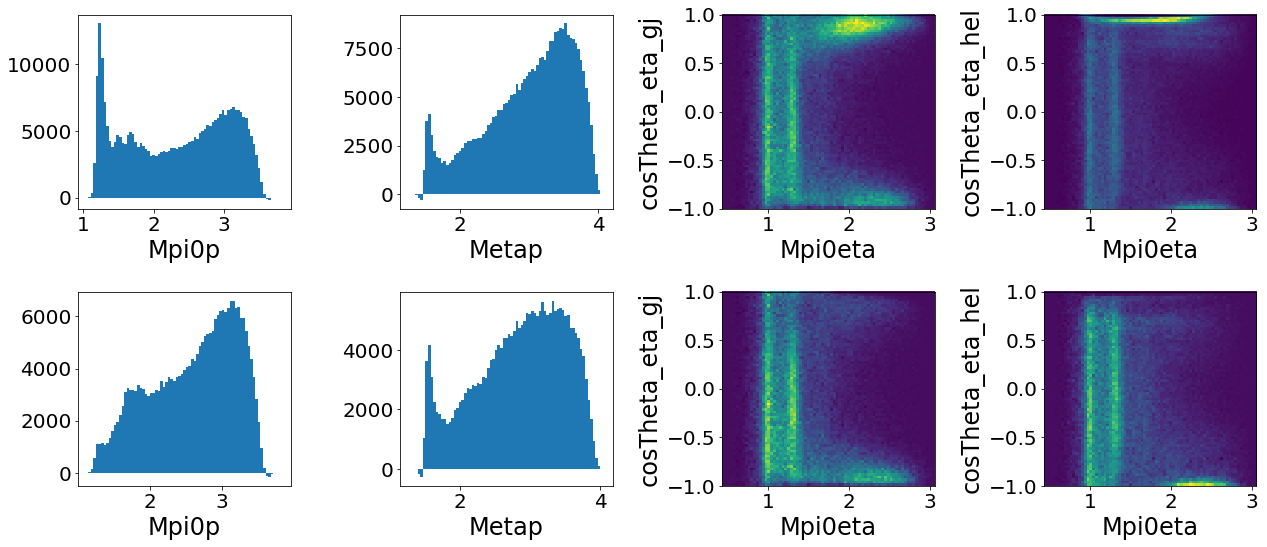

In [38]:
wanted_omega=arctan(data_tmp.Mpi0eta,*popt)
data_vh_selected=data_tmp[data_tmp.vanHove_omega<wanted_omega]

fig,axes=plt.subplots(2,4,figsize=(18,8))

vars=[
    ["Mpi0p"],
    ["Metap"],
    ["Mpi0eta","cosTheta_eta_gj"],
    ["Mpi0eta","cosTheta_eta_hel"]
]

irow=0
for ivar, var in  enumerate(vars):
    tmp=data_tmp#[data_tmp.cosTheta_pi0_cm>-0.2]
    if len(var)==1:
        _=axes[irow,ivar].hist(tmp[var[0]],bins=75,weights=tmp["weightASBS"])
        axes[irow,ivar].set_xlabel(var[0])
    else:
        _=axes[irow,ivar].hist2d(tmp[var[0]],tmp[var[1]],bins=(75,75),weights=tmp["weightASBS"])
        axes[irow,ivar].set_xlabel(var[0])
        axes[irow,ivar].set_ylabel(var[1])

irow=1
for ivar, var in  enumerate(vars):
    tmp=data_vh_selected#[data_tmp.cosTheta_pi0_cm>-0.2]
    if len(var)==1:
        _=axes[irow,ivar].hist(tmp[var[0]],bins=75,weights=tmp["weightASBS"])
        axes[irow,ivar].set_xlabel(var[0])
    else:
        _=axes[irow,ivar].hist2d(tmp[var[0]],tmp[var[1]],bins=(75,75),weights=tmp["weightASBS"])
        axes[irow,ivar].set_xlabel(var[0])
        axes[irow,ivar].set_ylabel(var[1])

        
plt.tight_layout()

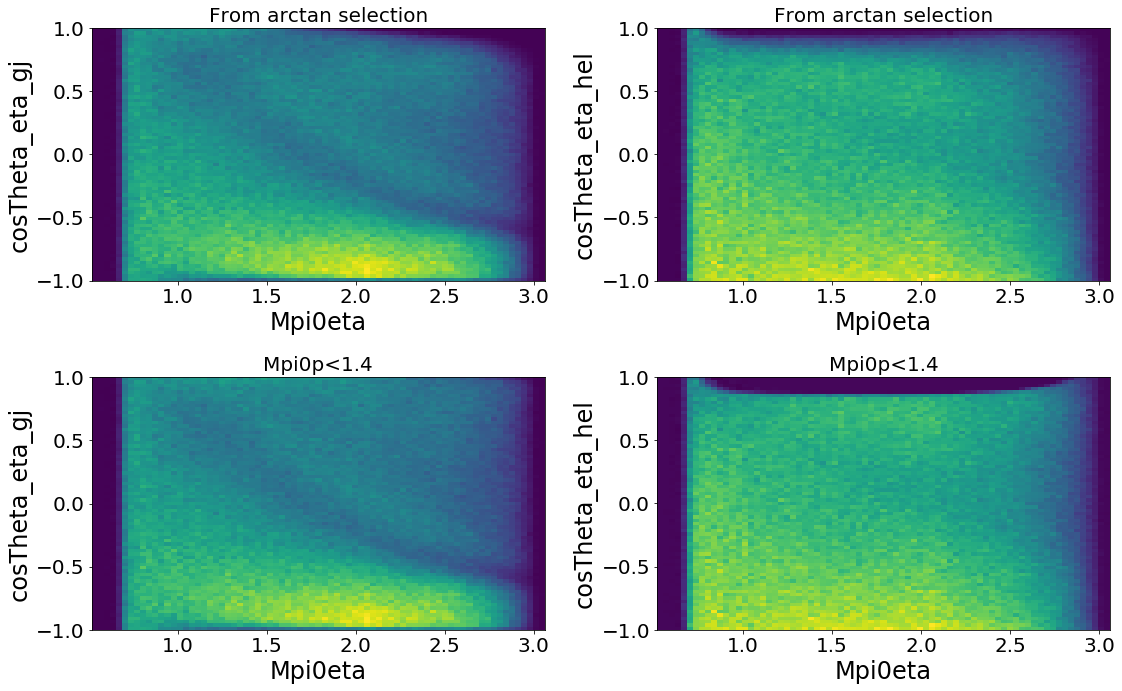

In [39]:
wanted_omega=arctan(acc_tmp.Mpi0eta,*popt)
acc_vh_selected=acc_tmp[acc_tmp.vanHove_omega<wanted_omega]

fig,axes=plt.subplots(2,2,figsize=(16,10))
axes=axes.flatten()

_=axes[0].hist2d(acc_vh_selected["Mpi0eta"],acc_vh_selected["cosTheta_eta_gj"],bins=(75,75),weights=acc_vh_selected["weightASBS"])
_=axes[1].hist2d(acc_vh_selected["Mpi0eta"],acc_vh_selected["cosTheta_eta_hel"],bins=(75,75),weights=acc_vh_selected["weightASBS"])
axes[0].set_ylabel("cosTheta_eta_gj")
axes[1].set_ylabel("cosTheta_eta_hel")
axes[0].set_xlabel("Mpi0eta")
axes[1].set_xlabel("Mpi0eta")
axes[0].set_title("From arctan selection")
axes[1].set_title("From arctan selection")

tmp=acc_tmp[acc_tmp.Mpi0p>1.4]
_=axes[2].hist2d(tmp["Mpi0eta"],tmp["cosTheta_eta_gj"],bins=(75,75),weights=tmp["weightASBS"])
_=axes[3].hist2d(tmp["Mpi0eta"],tmp["cosTheta_eta_hel"],bins=(75,75),weights=tmp["weightASBS"])
axes[2].set_ylabel("cosTheta_eta_gj")
axes[3].set_ylabel("cosTheta_eta_hel")
axes[2].set_xlabel("Mpi0eta")
axes[3].set_xlabel("Mpi0eta")
axes[2].set_title("Mpi0p<1.4")
axes[3].set_title("Mpi0p<1.4")

plt.tight_layout()

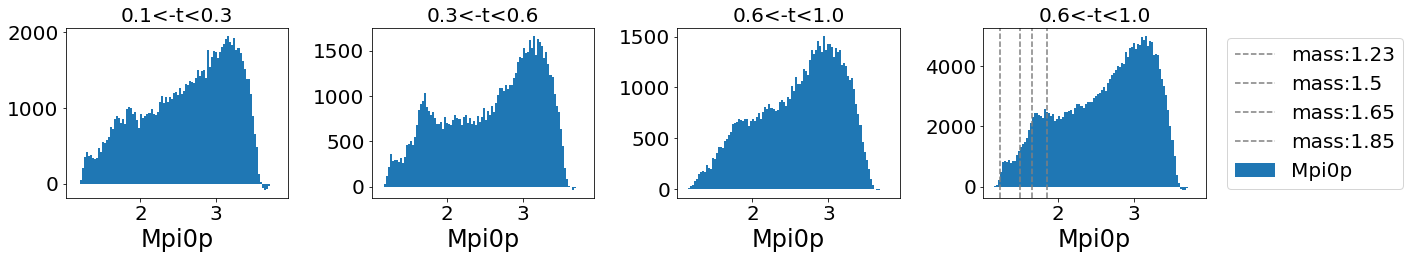

In [40]:
fig,axes=plt.subplots(1,4,figsize=(20,4))
_=axes[0].hist(data_vh_selected.loc[(data_vh_selected.mandelstam_t<0.3)&(data_vh_selected.mandelstam_t>0.1),"Mpi0p"],
               bins=100,
               weights=data_vh_selected.loc[(data_vh_selected.mandelstam_t<0.3)&(data_vh_selected.mandelstam_t>0.1),"weightASBS"])
axes[0].set_xlabel("Mpi0p")
axes[0].set_title(label="0.1<-t<0.3")

_=axes[1].hist(data_vh_selected.loc[(data_vh_selected.mandelstam_t<0.6)&(data_vh_selected.mandelstam_t>0.3),"Mpi0p"],
               bins=100,
               weights=data_vh_selected.loc[(data_vh_selected.mandelstam_t<0.6)&(data_vh_selected.mandelstam_t>0.3),"weightASBS"])
axes[1].set_xlabel("Mpi0p")
axes[1].set_title(label="0.3<-t<0.6")

_=axes[2].hist(data_vh_selected.loc[(data_vh_selected.mandelstam_t<1.0)&(data_vh_selected.mandelstam_t>0.6),"Mpi0p"],
               bins=100,
               weights=data_vh_selected.loc[(data_vh_selected.mandelstam_t<1.0)&(data_vh_selected.mandelstam_t>0.6),"weightASBS"])
axes[2].set_xlabel("Mpi0p")
axes[2].set_title(label="0.6<-t<1.0")

_=axes[3].hist(data_vh_selected["Mpi0p"],
               bins=100,
               weights=data_vh_selected["weightASBS"])
axes[3].set_xlabel("Mpi0p")
axes[3].set_title(label="0.6<-t<1.0")
for res_mass in res_masses:
    axes[3].axvline(res_mass,c='gray',linestyle='--',label="mass:{0}".format(res_mass))
axes[3].legend(bbox_to_anchor=(1.05,1))

plt.tight_layout()

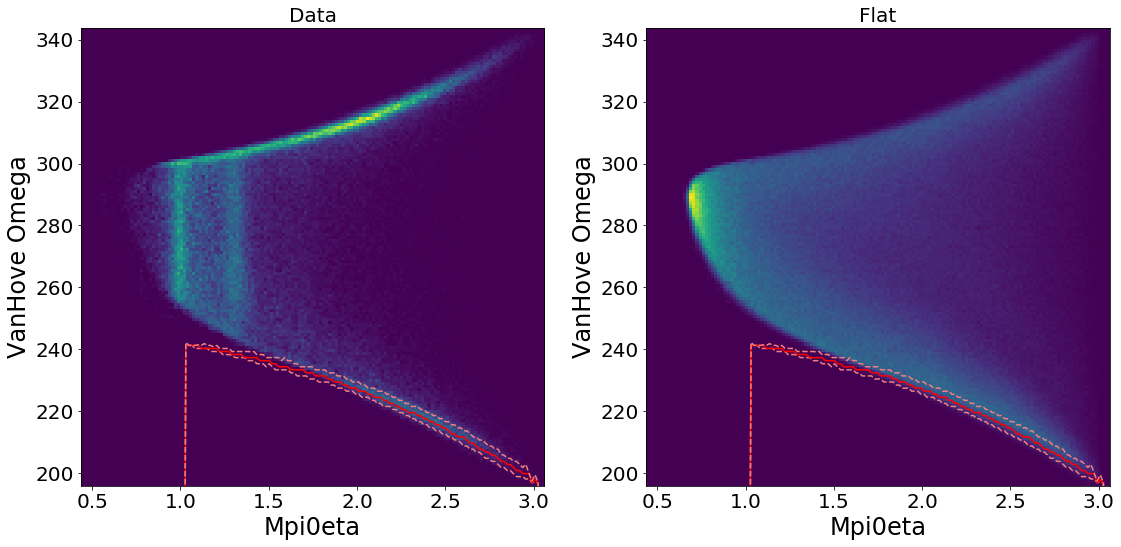

In [41]:
fig,axes=plt.subplots(1,2,figsize=(16,8))
edges=np.histogram2d(data_tmp["Mpi0eta"],data_tmp["vanHove_omega"],bins=(150,150))[1:]
_=axes[0].hist2d(data_tmp["Mpi0eta"],data_tmp["vanHove_omega"],bins=edges,weights=data_tmp["weightASBS"],vmin=0)
axes[0].set_xlabel("Mpi0eta")
axes[0].set_ylabel("VanHove Omega")
axes[0].set_title("Data")

tmp=data_tmp[(data_tmp.Metap<1.65)]
counts,edgex,edgey=np.histogram2d(tmp["Mpi0eta"],tmp["vanHove_omega"],bins=edges)
lowers=[]
uppers=[]
medians=[]
for col in range(len(counts)):
    lower,upper,median=getSigma(counts[col,:],16,90)
    lowers.append(lower)
    uppers.append(upper)
    medians.append(median)
axes[0].plot(edgex[:-1],lowers,c='lightcoral',linestyle='--')
axes[0].plot(edgex[:-1],medians,c='red',linestyle='-')
axes[0].plot(edgex[:-1],uppers,c='lightcoral',linestyle='--')


_=axes[1].hist2d(acc_tmp["Mpi0eta"],acc_tmp["vanHove_omega"],bins=edges,weights=acc_tmp["weightASBS"],vmin=0)
axes[1].set_xlabel("Mpi0eta")
axes[1].set_ylabel("VanHove Omega")
axes[1].set_title("Flat")
axes[1].plot(edgex[:-1],lowers,c='lightcoral',linestyle='--')
axes[1].plot(edgex[:-1],medians,c='red',linestyle='-')
axes[1].plot(edgex[:-1],uppers,c='lightcoral',linestyle='--')

plt.tight_layout()

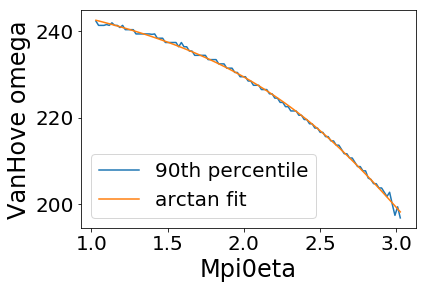

In [42]:
from scipy.optimize import curve_fit

def arctan(x,a,b,c,d):
    return a*np.arctan(b*(x-c))+d

percentiles=uppers
percentiles=np.array(percentiles)
percentilesGT0=np.where(percentiles>0)
percentiles=percentiles[percentilesGT0]
edges=edgex[:-1][percentilesGT0]
popt2, pcov = curve_fit(arctan, edges, percentiles, p0=[43.90795447,  -0.86608286,   3.08704162, 195.64804878])
plt.plot(edges,percentiles,label='90th percentile')
plt.plot(edges,arctan(edges,*popt2),label='arctan fit')
plt.xlabel("Mpi0eta")
plt.ylabel("VanHove omega")
plt.legend()

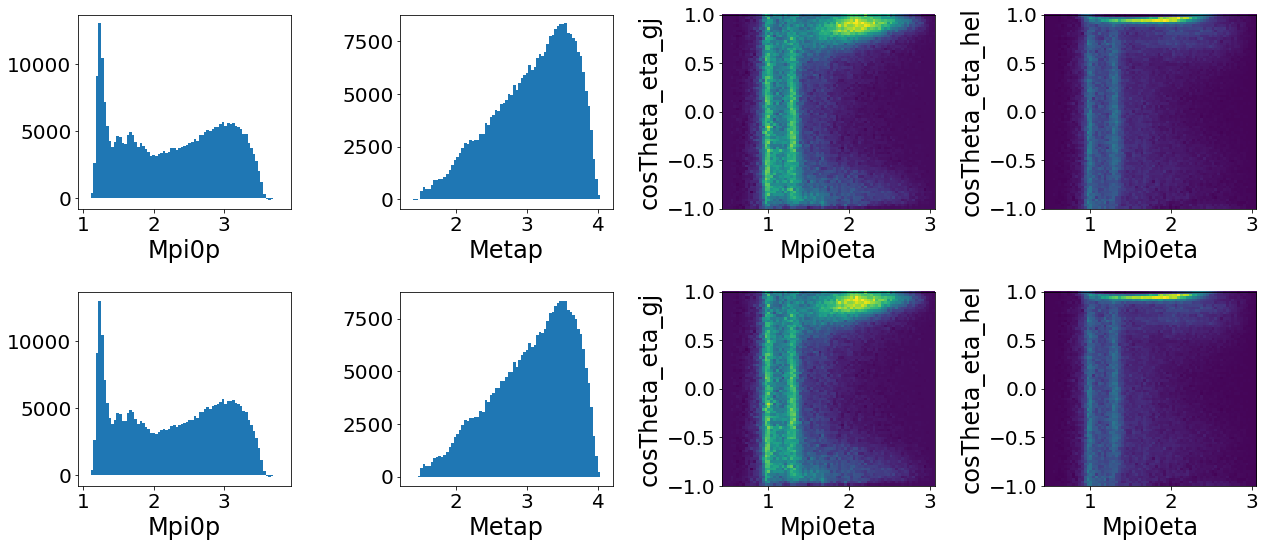

In [43]:
wanted_omega2=arctan(data_tmp.Mpi0eta,*popt2)
data_vh_selected=data_tmp[data_tmp.vanHove_omega>wanted_omega2]

fig,axes=plt.subplots(2,4,figsize=(18,8))

vars=[
    ["Mpi0p"],
    ["Metap"],
    ["Mpi0eta","cosTheta_eta_gj"],
    ["Mpi0eta","cosTheta_eta_hel"]
]

irow=0
for ivar, var in  enumerate(vars):
    tmp=data_vh_selected#[data_tmp.cosTheta_pi0_cm>-0.2]
    if len(var)==1:
        _=axes[irow,ivar].hist(tmp[var[0]],bins=75,weights=tmp["weightASBS"])
        axes[irow,ivar].set_xlabel(var[0])
    else:
        _=axes[irow,ivar].hist2d(tmp[var[0]],tmp[var[1]],bins=(75,75),weights=tmp["weightASBS"])
        axes[irow,ivar].set_xlabel(var[0])
        axes[irow,ivar].set_ylabel(var[1])

irow=1
for ivar, var in  enumerate(vars):
    tmp=data_vh_selected#[data_tmp.cosTheta_pi0_cm>-0.2]
    if len(var)==1:
        _=axes[irow,ivar].hist(tmp[var[0]],bins=75,weights=tmp["weightASBS"])
        axes[irow,ivar].set_xlabel(var[0])
    else:
        _=axes[irow,ivar].hist2d(tmp[var[0]],tmp[var[1]],bins=(75,75),weights=tmp["weightASBS"])
        axes[irow,ivar].set_xlabel(var[0])
        axes[irow,ivar].set_ylabel(var[1])

        
plt.tight_layout()

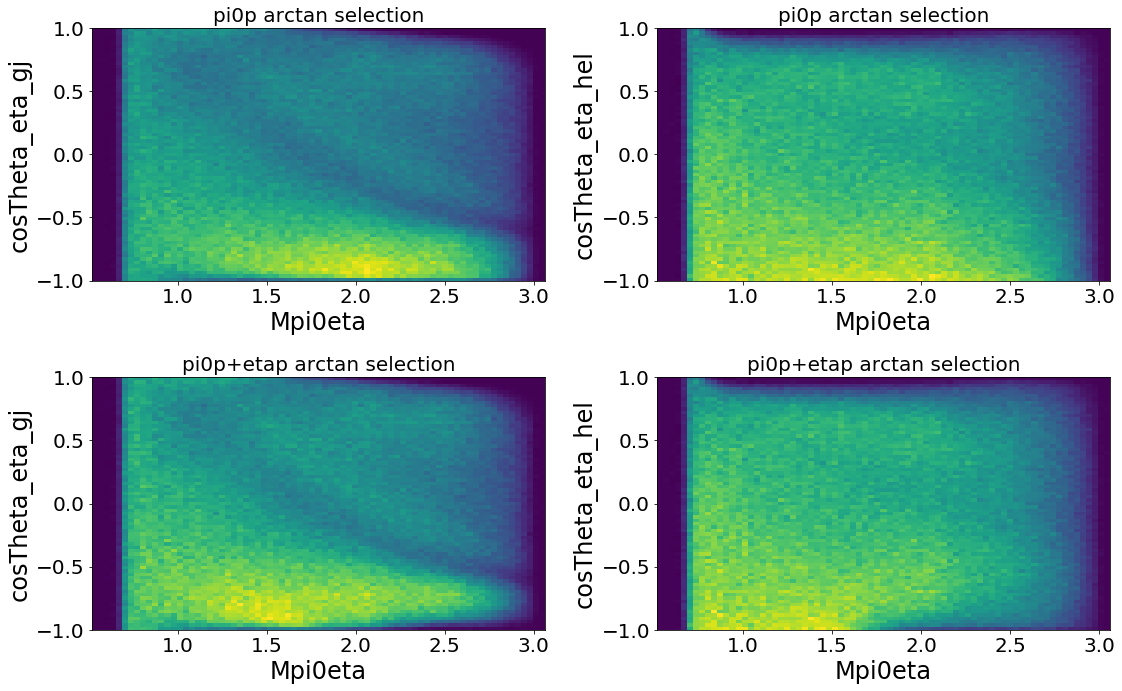

In [51]:
wanted_omega=arctan(acc_tmp.Mpi0eta,*popt)
acc_vh_selected=acc_tmp[acc_tmp.vanHove_omega<wanted_omega]
wanted_omega2=arctan(acc_tmp.Mpi0eta,*popt2)
acc_vh_selected2=acc_tmp[(acc_tmp.vanHove_omega<wanted_omega)&(acc_tmp.vanHove_omega>wanted_omega2)]

fig,axes=plt.subplots(2,2,figsize=(16,10))
axes=axes.flatten()

_=axes[0].hist2d(acc_vh_selected["Mpi0eta"],acc_vh_selected["cosTheta_eta_gj"],bins=(75,75),weights=acc_vh_selected["weightASBS"])
_=axes[1].hist2d(acc_vh_selected["Mpi0eta"],acc_vh_selected["cosTheta_eta_hel"],bins=(75,75),weights=acc_vh_selected["weightASBS"])
axes[0].set_ylabel("cosTheta_eta_gj")
axes[1].set_ylabel("cosTheta_eta_hel")
axes[0].set_xlabel("Mpi0eta")
axes[1].set_xlabel("Mpi0eta")
axes[0].set_title("pi0p arctan selection")
axes[1].set_title("pi0p arctan selection")

_=axes[2].hist2d(acc_vh_selected2["Mpi0eta"],acc_vh_selected2["cosTheta_eta_gj"],bins=(75,75),weights=acc_vh_selected2["weightASBS"])
_=axes[3].hist2d(acc_vh_selected2["Mpi0eta"],acc_vh_selected2["cosTheta_eta_hel"],bins=(75,75),weights=acc_vh_selected2["weightASBS"])
axes[2].set_ylabel("cosTheta_eta_gj")
axes[3].set_ylabel("cosTheta_eta_hel")
axes[2].set_xlabel("Mpi0eta")
axes[3].set_xlabel("Mpi0eta")
axes[2].set_title("pi0p+etap arctan selection")
axes[3].set_title("pi0p+etap arctan selection")

plt.tight_layout()

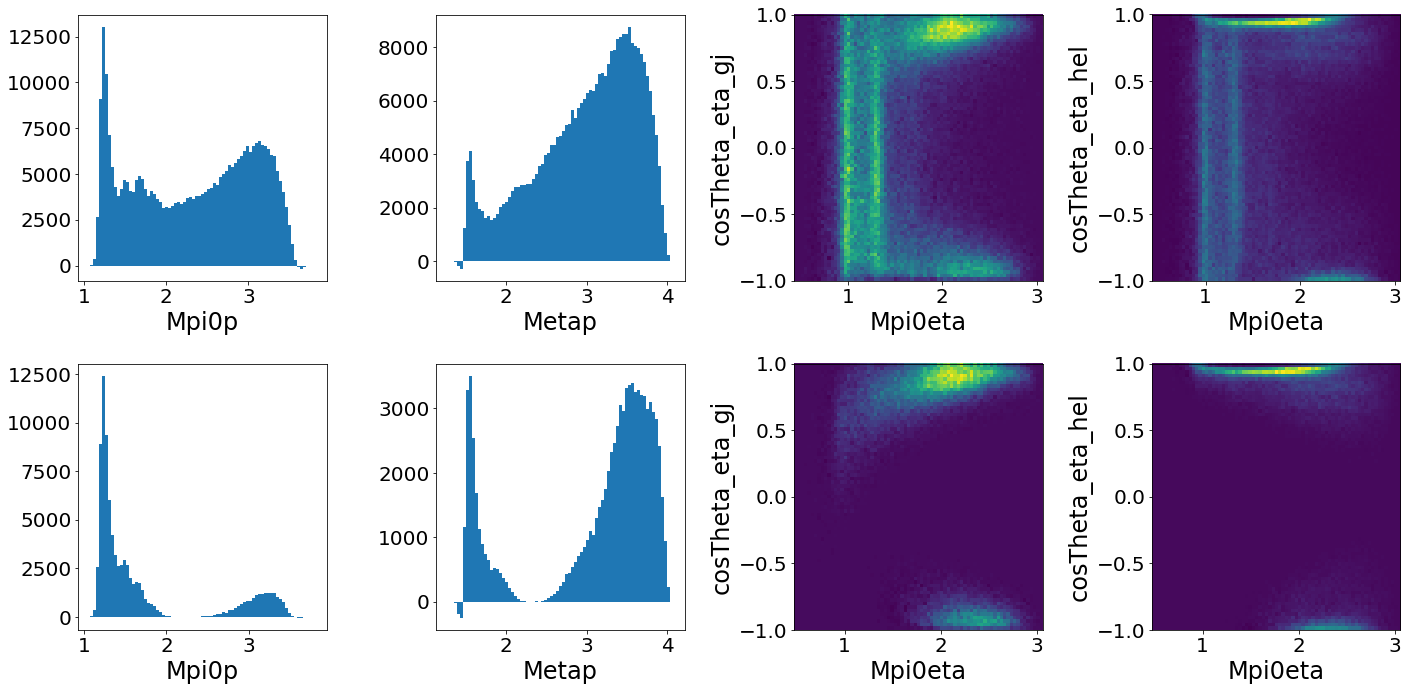

In [46]:
fig,axes=plt.subplots(2,4,figsize=(20,10))
axes=axes.flatten()

# Standard selections with Delta in
axes[0].hist(data_tmp.Mpi0p,bins=75,weights=data_tmp.weightASBS)
axes[0].set_xlabel("Mpi0p")
axes[1].hist(data_tmp.Metap,bins=75,weights=data_tmp.weightASBS)
axes[1].set_xlabel("Metap")
axes[2].hist2d(data_tmp.Mpi0eta,data_tmp.cosTheta_eta_gj,bins=(75,75),weights=data_tmp.weightASBS)
axes[2].set_xlabel("Mpi0eta")
axes[2].set_ylabel("cosTheta_eta_gj")
axes[3].hist2d(data_tmp.Mpi0eta,data_tmp.cosTheta_eta_hel,bins=(75,75),weights=data_tmp.weightASBS)
axes[3].set_xlabel("Mpi0eta")
axes[3].set_ylabel("cosTheta_eta_hel")

# What I propose to remove
wanted_omega=arctan(data_tmp.Mpi0eta,*popt)
wanted_omega2=arctan(data_tmp.Mpi0eta,*popt2)
data_vh_selected_2=data_tmp[(data_tmp.vanHove_omega>wanted_omega)|(data_tmp.vanHove_omega<wanted_omega2)]

axes[4].hist(data_vh_selected_2.Mpi0p,bins=75,weights=data_vh_selected_2.weightASBS)
axes[4].set_xlabel("Mpi0p")
axes[5].hist(data_vh_selected_2.Metap,bins=75,weights=data_vh_selected_2.weightASBS)
axes[5].set_xlabel("Metap")
axes[6].hist2d(data_vh_selected_2.Mpi0eta,data_vh_selected_2.cosTheta_eta_gj,bins=(75,75),weights=data_vh_selected_2.weightASBS)
axes[6].set_xlabel("Mpi0eta")
axes[6].set_ylabel("cosTheta_eta_gj")
axes[7].hist2d(data_vh_selected_2.Mpi0eta,data_vh_selected_2.cosTheta_eta_hel,bins=(75,75),weights=data_vh_selected_2.weightASBS)
axes[7].set_xlabel("Mpi0eta")
axes[7].set_ylabel("cosTheta_eta_hel")
plt.tight_layout()

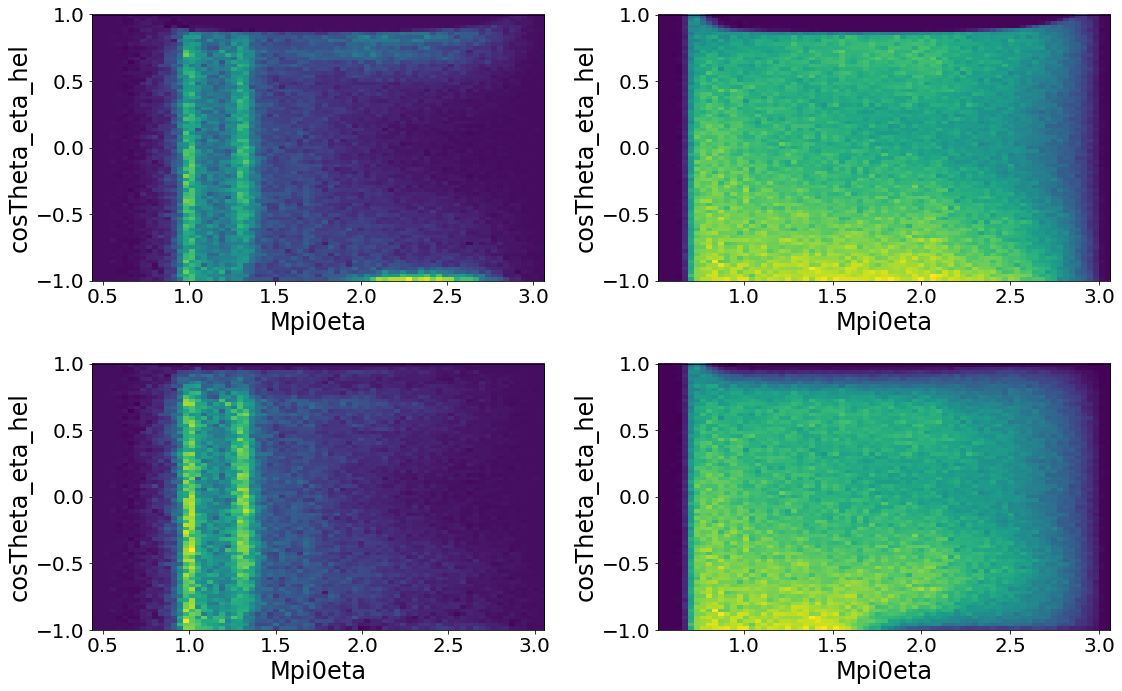

In [59]:
# Final inputs to amptools
fig,axes=plt.subplots(2,2,figsize=(16,10))
axes=axes.flatten()

# Standard selections with Delta in
tmp = data_tmp[data_tmp.Mpi0p>1.4]
axes[0].hist2d(tmp.Mpi0eta,tmp.cosTheta_eta_hel,bins=(75,75),weights=tmp.weightASBS)
axes[0].set_xlabel("Mpi0eta")
axes[0].set_ylabel("cosTheta_eta_hel")

tmp = acc_tmp[acc_tmp.Mpi0p>1.4]
axes[1].hist2d(tmp.Mpi0eta,tmp.cosTheta_eta_hel,bins=(75,75),weights=tmp.weightASBS)
axes[1].set_xlabel("Mpi0eta")
axes[1].set_ylabel("cosTheta_eta_hel")

# What VH removes
wanted_omega=arctan(data_tmp.Mpi0eta,*popt)
wanted_omega2=arctan(data_tmp.Mpi0eta,*popt2)
data_vh_selected_2=data_tmp[(data_tmp.vanHove_omega<wanted_omega)&(data_tmp.vanHove_omega>wanted_omega2)]
axes[2].hist2d(data_vh_selected_2.Mpi0eta,data_vh_selected_2.cosTheta_eta_hel,bins=(75,75),weights=data_vh_selected_2.weightASBS)
axes[2].set_xlabel("Mpi0eta")
axes[2].set_ylabel("cosTheta_eta_hel")

wanted_omega=arctan(acc_tmp.Mpi0eta,*popt)
wanted_omega2=arctan(acc_tmp.Mpi0eta,*popt2)
acc_vh_selected_2=acc_tmp[(acc_tmp.vanHove_omega<wanted_omega)&(acc_tmp.vanHove_omega>wanted_omega2)]
axes[3].hist2d(acc_vh_selected_2.Mpi0eta,acc_vh_selected_2.cosTheta_eta_hel,bins=(75,75),weights=acc_vh_selected_2.weightASBS)
axes[3].set_xlabel("Mpi0eta")
axes[3].set_ylabel("cosTheta_eta_hel")

plt.tight_layout()

# Final Equation

$${-29.61317407*arctan(-0.9877663*M(\pi^0\eta)+2.77936736)}+330.46008765$$

$${45.26878219*arctan(-0.88242654*M(\pi^0\eta)+3.14340627)}+193.59347205$$